In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
def f_channel(x,y,z):
    led_x = 5
    led_y = 5
    led_z = 2.5
    theta = 60
    m=-np.log10(2)/np.log10(np.cos(np.deg2rad(theta)))
    p_total = 60
    Adet=1e-4
    Ts=1
    index=1.5
    FOV=60
    
    # distance between led and pd
    d= np.sqrt(np.power(led_x-x,2)+np.power(led_y-y,2))
    
    # angle between led and pd
    theta_T = np.arctan(d/(led_z-z))
    theta_R = theta_T
    # Transmitted signal power
    m1= -np.log10(2)/np.log10(np.cos(np.rad2deg(theta)))
    T_S = p_total *(m1+1)/(2*np.pi)*(np.cos(theta_T))
    
    # Received signal power to pd
    Aeff= Adet*np.cos(theta_R)
    G_conv = index*index/np.sin(np.deg2rad(FOV))
    d2 = np.sqrt(np.power(d,2)+np.power(led_z-z,2))
    H_los = Aeff*T_S*G_conv/(d2*d2)
    if (FOV >= np.rad2deg(theta_R)):
        return H_los*p_total
    else:
        return 0

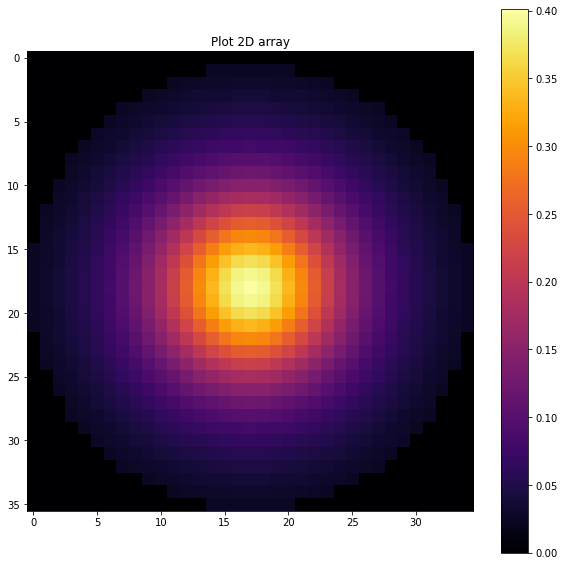

In [3]:
H=np.zeros([100,100])
for i in range(100):
    for j in range(100):
        H[i][j] = f_channel(i/10, j/10, 1.5)
        #print(i,j,H[i][j])

fig = plt.figure(figsize=(10,10))
plt.imshow(H[32:68,33:68], cmap="inferno")
plt.title("Plot 2D array")
plt.colorbar()
plt.show()

In [52]:
x, y, z = 5, 6.73, 1.5
d = np.sqrt(math.pow(x-5,2)+math.pow(y-5,2))

print(f_channel(5,6,1.5))
print(f_channel(6,6,z))
print('Distance : ', d)


0.10025130324717278
0.04455613477652123
Distance :  1.7300000000000004


In [51]:
f_channel(3.8,3.7,1.5)

0

In [5]:
def distance_cal(user_x,user_y):
    led_x, led_y, led_z = 5, 5, 2
    user_z= 1.5
    d = np.sqrt(math.pow(user_x-led_x,2) + math.pow(user_y-led_y,2))
    h = f_channel(user_x,user_y,user_z)
    return d, h

In [6]:
# Defined as near-user if the distance is less than 0.7m. Defined as far-user if the distance is larger than 0.7m
def get_channel_gain():
    H_f, H_n = 0, 0
    while(H_f==0 or H_n == 0):
        x = random.randrange(350,650)/100
        y = random.randrange(350,650)/100
        
        d, h = distance_cal(x,y)
        if h != 0 and d <=0.7:
            H_n = h
        elif h !=0 and d > 0.7:
            H_f = h
    return H_f, H_n

In [7]:
def theory_f(tx_snr, H_f, p_n):
    return 0.25*(math.erfc(0.5*H_f*np.sqrt(tx_snr))+math.erfc((1-p_n-0.5)*H_f*np.sqrt(tx_snr)))

def theory_n(tx_snr, H_n, p_n):
    return 0.5*math.erfc(p_n*H_n/2*np.sqrt(tx_snr))

In [8]:
def target_power_alloc(EbN0, H_f, H_n):
    tx_snr = math.pow(10,(EbN0/10))
    BER = np.zeros(500)
    for i in range(1, 501):
        p_n = i/1000
        BER[i-1] = abs(theory_f(tx_snr, H_f, p_n) - theory_n(tx_snr, H_n, p_n))
    target_pn= (np.argmin(BER)+1)/1000
    return target_pn

In [9]:
EbN0 = 60

H_f, H_n = get_channel_gain()

#H_n = 0.10025130324717278
#H_f = 0.04455613477652123

In [10]:
p_n = target_power_alloc(EbN0, H_f, H_n)
print(H_f, H_n, p_n)

0.028022075343859257 0.2315113247827161 0.098


In [11]:
n = 10000
for EbN0 in range(10,110,10):
    f = open('test_EbN0_'+ str(EbN0)+'.csv', 'w')
    f.write('EbN0,H_f,H_n,p_n\n')
    for i in range(n):
        H_f, H_n = get_channel_gain()
        p_n = target_power_alloc(EbN0, H_f, H_n)
        f.write(str(EbN0)+','+str(H_f)+','+str(H_n)+','+str(p_n)+'\n')
    f.close()

In [12]:
n = 100000
f = open('learning_dataset.csv', 'w')
f.write('EbN0,H_f,H_n,p_n\n')
for EbN0 in range(10,110,10): 
    for i in range(n):
        H_f, H_n = get_channel_gain()
        p_n = target_power_alloc(EbN0, H_f, H_n)
        f.write(str(EbN0)+','+str(H_f)+','+str(H_n)+','+str(p_n)+'\n')
f.close()

In [13]:
n = 100000
f = open('test_dataset.csv', 'w')
f.write('EbN0,H_f,H_n,p_n\n')
for EbN0 in range(10,110,10): 
    for i in range(n):
        H_f, H_n = get_channel_gain()
        p_n = target_power_alloc(EbN0, H_f, H_n)
        f.write(str(EbN0)+','+str(H_f)+','+str(H_n)+','+str(p_n)+'\n')
f.close()